In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [36]:
df = pd.read_csv('data/train.txt', sep='\n+', header=None)
df[['Text', 'Tag']] = df[0].str.split(' ', expand=True)
df = df.drop(columns=[0])
df

<ipython-input-36-bb020b5f2c7d>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('data/train.txt', sep='\n+', header=None)


,Text,Tag
0,"""",O
1,Если,O
2,Миронов,B-PER
3,занял,O
4,столь,O
...,...,...
156685,метро,O
156686,7,O
156687,июля,O
156688,2005г,O


# EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156690 entries, 0 to 156689
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Text    156690 non-null  object
 1   Tag     156690 non-null  object
dtypes: object(2)
memory usage: 2.4+ MB


In [6]:
df.describe(include='all')

,Text,Tag
count,156690,156690
unique,26821,7
top,",",O
freq,9538,132788


In [7]:
tag_counts = df['Tag'].explode().value_counts()
tag_counts = tag_counts.drop(index='O')
tag_counts

,count
Tag,
B-PER,6359
B-ORG,5084
B-LOC,4335
I-PER,3925
I-ORG,3227
I-LOC,972


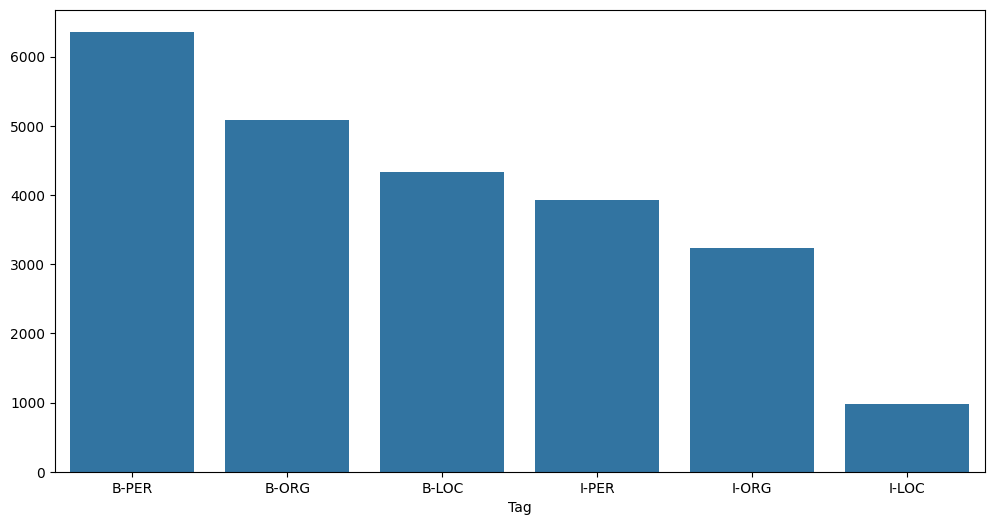

In [8]:
plt.figure(figsize=(12, 6))
sns.barplot(x=tag_counts.index, y=tag_counts.values)
plt.show()

Удалим повторяющиеся

In [9]:
df = df.drop_duplicates().copy()
print(df.duplicated().sum())
df

0


,Text,Tag
0,"""",O
1,Если,O
2,Миронов,B-PER
3,занял,O
4,столь,O
...,...,...
156664,взносы,O
156667,2МРОТ,O
156676,авторы,O
156682,взрывов,O


Удалим стоп слова

In [10]:
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))
def remove_stopwords(text):
    if text.lower() not in stop_words:
      return text.lower()


df['Text'] = df['Text'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
df = df.dropna()
df

,Text,Tag
0,"""",O
2,миронов,B-PER
3,занял,O
4,столь,O
5,оппозиционную,O
...,...,...
156664,взносы,O
156667,2мрот,O
156676,авторы,O
156682,взрывов,O


In [13]:
df.to_csv('data/train_clean.csv', index=False)

In [14]:
df = pd.read_csv('data/train_clean.csv')
df

,Text,Tag
0,"""",O
1,миронов,B-PER
2,занял,O
3,столь,O
4,оппозиционную,O
...,...,...
28132,взносы,O
28133,2мрот,O
28134,авторы,O
28135,взрывов,O


# NN


In [17]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

In [20]:

words = list(set(df['Text'].explode()))
tags = list(set(df['Tag'].explode()))


tokenizer_words = Tokenizer()
tokenizer_words.fit_on_texts(words)

tokenizer_tags = Tokenizer()
tokenizer_tags.fit_on_texts(tags)

X_train = tokenizer_words.texts_to_sequences(train_df['Text'])
X_test = tokenizer_words.texts_to_sequences(test_df['Text'])


y_train = tokenizer_tags.texts_to_sequences(train_df['Tag'])
y_test = tokenizer_tags.texts_to_sequences(test_df['Tag'])


max_len = max([len(i) for i in X_train + X_test])
X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

y_train = pad_sequences(y_train, maxlen=max_len, padding='post')
y_test = pad_sequences(y_test, maxlen=max_len, padding='post')

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, TimeDistributed


vocab_size_words = len(tokenizer_words.word_index) + 1
vocab_size_tags = len(tokenizer_tags.word_index) + 1
embedding_dim = 100
lstm_units = 128


model = Sequential()
model.add(Embedding(input_dim=vocab_size_words, output_dim=embedding_dim, input_length=max_len))
model.add(LSTM(lstm_units, return_sequences=True))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(vocab_size_tags, activation='softmax')))


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [22]:

history = model.fit(X_train, np.expand_dims(y_train, -1),
                    validation_data=(X_test, np.expand_dims(y_test, -1)),
                    epochs=5,
                    batch_size=32)

Epoch 1/5
792/792 ━━━━━━━━━━━━━━━━━━━━ 40s 47ms/step - accuracy: 0.9195 - loss: 0.3035 - val_accuracy: 0.9487 - val_loss: 0.1488
Epoch 2/5
792/792 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - accuracy: 0.9585 - loss: 0.1102 - val_accuracy: 0.9500 - val_loss: 0.1659
Epoch 3/5
792/792 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - accuracy: 0.9755 - loss: 0.0566 - val_accuracy: 0.9351 - val_loss: 0.1907
Epoch 4/5
792/792 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.9834 - loss: 0.0404 - val_accuracy: 0.9028 - val_loss: 0.2521
Epoch 5/5
792/792 ━━━━━━━━━━━━━━━━━━━━ 42s 46ms/step - accuracy: 0.9878 - loss: 0.0290 - val_accuracy: 0.9025 - val_loss: 0.2755


In [23]:

loss, accuracy = model.evaluate(X_test, np.expand_dims(y_test, -1))
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9037 - loss: 0.2701
Test Loss: 0.27548596262931824
Test Accuracy: 0.9025112986564636


Попробуем улучшить качество модели. Для этого добавим GRU слой и заменим Dropout на BatchNormalization

In [33]:
from keras.layers import GRU, BatchNormalization
model = Sequential()
model.add(Embedding(input_dim=vocab_size_words, output_dim=embedding_dim, input_length=max_len))
model.add(LSTM(lstm_units, return_sequences=True))
model.add(BatchNormalization())
model.add(GRU(lstm_units, return_sequences=True))
model.add(BatchNormalization())
model.add(TimeDistributed(Dense(vocab_size_tags, activation='softmax')))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [34]:
history = model.fit(X_train, np.expand_dims(y_train, -1),
                    validation_data=(X_test, np.expand_dims(y_test, -1)),
                    epochs=5,
                    batch_size=32)

Epoch 1/5
792/792 ━━━━━━━━━━━━━━━━━━━━ 56s 63ms/step - accuracy: 0.9249 - loss: 0.3244 - val_accuracy: 0.9534 - val_loss: 0.1382
Epoch 2/5
792/792 ━━━━━━━━━━━━━━━━━━━━ 51s 64ms/step - accuracy: 0.9768 - loss: 0.0668 - val_accuracy: 0.9526 - val_loss: 0.1726
Epoch 3/5
792/792 ━━━━━━━━━━━━━━━━━━━━ 84s 67ms/step - accuracy: 0.9882 - loss: 0.0307 - val_accuracy: 0.9513 - val_loss: 0.1996
Epoch 4/5
792/792 ━━━━━━━━━━━━━━━━━━━━ 56s 71ms/step - accuracy: 0.9896 - loss: 0.0213 - val_accuracy: 0.9494 - val_loss: 0.2119
Epoch 5/5
792/792 ━━━━━━━━━━━━━━━━━━━━ 53s 67ms/step - accuracy: 0.9906 - loss: 0.0181 - val_accuracy: 0.9506 - val_loss: 0.2244


In [35]:
loss, accuracy = model.evaluate(X_test, np.expand_dims(y_test, -1))
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9497 - loss: 0.2192
Test Loss: 0.22436261177062988
Test Accuracy: 0.9505744576454163
